In [2]:
import os
import math
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from scipy.stats import gaussian_kde
import seaborn as sns
from scipy.optimize import curve_fit
from matplotlib import pyplot
import numpy as np
from sklearn.linear_model import LinearRegression
import warnings

warnings.filterwarnings('ignore')


In [3]:

def getAllRateInfo(path):
    res=pd.DataFrame()
    files=[x for x in os.listdir(path) if 'RateConst.csv' in x  ]
    # files=[x for x in os.listdir(path) if 'RateConst.csv' in x and 'CPSM_MOUSE.' in x  ]
    # files=[x for x in os.listdir(path) if 'RateConst.csv' in x and 'CH60_MOUSE.' in x  ]
    # files=[x for x in os.listdir(path) if 'RateConst.csv' in x and 'FAS_MOUSE.' in x  ]
    for f in tqdm(files):
        try:
            temp=pd.read_csv(os.path.join(path,f))
            temp=temp.dropna()
            temp['Protein']=f.replace('.RateConst.csv','')
            res=pd.concat([res,temp])
        except Exception as exp:
            print(f,exp)
    res.columns=[x.strip() for x in res.columns]
    return res
def read_n_merge(orignial_data,skip,file,folder_path):
    file_data=pd.read_csv(os.path.join(folder_path,file),skiprows=skip,index_col=False)
    file_data.columns=[x.strip() for x in file_data.columns]
    isparsed=(set(['Peptide', 'UniqueToProtein', 'Exchangeable Hydrogens', 'Charge',
       'm/z(Sequence)', 'M0', 'M1', 'M2', 'M3', 'M4']).issubset(set(file_data.columns)))
    isparsed=isparsed and file_data.shape[0]>0    
    if isparsed:
        file_data['Protein']=file.replace('.Quant.csv','')
        orignial_data=pd.concat([orignial_data,file_data])       
    return [isparsed,orignial_data]

def get_df_all_quant_files(path):
    files=[x for x in os.listdir(path) if '.Quant.csv' in x  ]
    # files=[x for x in os.listdir(path) if 'CPSM_MOUSE.Quant.csv' in x  ] 
    # files=[x for x in os.listdir(path) if 'CH60_MOUSE.Quant.csv' in x  ] 
    # files=[x for x in os.listdir(path) if 'FAS_MOUSE.Quant.csv' in x  ]      
    all_data=pd.DataFrame()  
        
    for index in tqdm(range(len(files))):            
        res=read_n_merge(all_data,1,files[index],path)
        # print(res)
        if res[0]:
            all_data=res[1]
        else:
            all_data=read_n_merge(all_data,3,files[index],path)[1]
    all_data=all_data.reset_index(drop=True)
    all_data.columns=[x.strip() for x in all_data.columns]
    return all_data

In [4]:
path=r"\\UT321319\Shared_Folder\NEH_Dependence\liverpool_heart"
quant=get_df_all_quant_files(path)
rate=getAllRateInfo(path)

100%|██████████| 1267/1267 [00:57<00:00, 21.89it/s]


In [5]:
merged=pd.merge(quant,rate,left_on=['Peptide','Charge'],right_on=['Peptides','Charge'])
merged=merged[merged['Rsquared']>0.8].reset_index(drop=True)
merged=merged.reset_index(drop=True)
# quant=merged.copy()

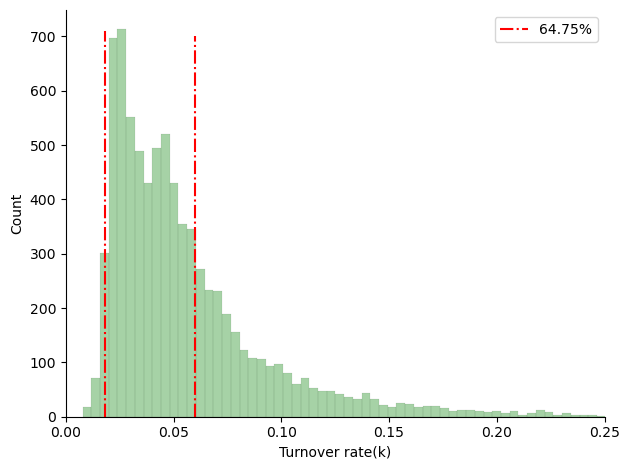

In [8]:
l_k,u_k=0.018,0.06
sns.histplot(merged.RateConstants,color='green',alpha=0.35)
plt.xlim(0,0.25)
plt.vlines(x=l_k,ymin=0,ymax=710,colors='r',ls="-.",
           label=f"{100*merged[(merged.RateConstants>=l_k)&(merged.RateConstants<=u_k)].shape[0]/merged.shape[0]:.2f}%")
plt.vlines(x=u_k,ymin=0,ymax=700,colors='r',ls="-.")
plt.xlabel("Turnover rate(k)")
plt.legend()
# merged[(merged.RateConstants>=0.07)&(merged.RateConstants<=0.21)].shape[0]/merged.shape[0]

ax=plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig("heart_k_dist.jpeg",dpi=900)


In [ ]:
# rate.columns

In [ ]:
# for i in merged.columns:
#     print(i)